In [1]:
from config import SEQ_LENGTH, FRAMERATE, CHUNK, FFT_SIZE
import generate_wav_samples as gen
from config import MORSE_CHR
import generator_test as gt

from tensorflow import keras
import librosa
import librosa.display
import scipy.io.wavfile
import sklearn
import numpy as np
import matplotlib.pyplot as plt
import os
import itertools
from tqdm import tqdm
from tensorflow.keras import backend as K
from tensorflow.keras import regularizers
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Conv1D, MaxPooling1D, Add, Concatenate
from tensorflow.keras.layers import Input, Dense, Activation,TimeDistributed, GlobalMaxPooling1D
from tensorflow.keras.layers import Reshape, Lambda, Dropout, Bidirectional, Permute, BatchNormalization
from tensorflow.keras.models import Model
from tensorflow.keras.layers import GRU, SimpleRNN,LSTM
from tensorflow.keras.optimizers import SGD, Adam, RMSprop
from tensorflow.keras.preprocessing import image
import tensorflow.keras.callbacks
import pickle
import Levenshtein
import string
import pandas as pd
import bz2
from matplotlib import pyplot

### Callbacks

In [2]:
class VizCallback(tensorflow.keras.callbacks.Callback):
    def __init__(self, run_name, test_func, X):
        self.test_func = test_func
        self.output_dir = os.path.join('rnn_output', run_name)
        self.X = X

    def show_edit_distance(self, num):
        print('edit distance: ', num)

    def on_epoch_end(self, epoch, logs={}):
        self.model.save_weights(os.path.join(self.output_dir, 'weights%02d.h5' % (epoch)))
        
        dec_len = 10
        print(self.X[0].shape)
        for i in range(dec_len):
            labels = self.X[1][i:i+1]
            print('labels: ', labels_to_text([int(e) for e in labels[0]]))
        
        word_batch = self.X[0][:dec_len]
        res = decode_batch(self.test_func, word_batch)
        print()
        print('result lens: ', len(res))
        for e in res[:dec_len]:
            print(e)
        
        len_for_cer_count = 5000
        word_batch = self.X[0][:len_for_cer_count]
        res = decode_batch(self.test_func, word_batch)
        print()
        
        cers = []
        for i, t in enumerate(self.X[1][:len_for_cer_count]):
            true = labels_to_text(t)
            pred = res[i]

            c = cer(true, pred)

            cers.append(c)

        print(np.mean(cers))
            
def cer(true, pred):
    t = ''.join(true).strip()
    p = ''.join(pred).strip()
    distance = Levenshtein.distance(t, p)
    return distance / len(t) if len(t) > 0 else len(p)

def ctc_lambda_func(args):
    y_pred, labels, input_length, label_length = args
    bc = K.ctc_batch_cost(labels, y_pred, input_length, label_length)
    return bc

def labels_to_text(i):
    return [MORSE_CHR[e] for e in i]

def decode_batch2(test_func, word_batch):
    out = test_func([word_batch])[0]
    ret = []
    print(np.argmax(out, axis = -1))
    return np.argmax(out, axis = -1)


def decode_batch(test_func, word_batch):
    out = test_func([word_batch])[0]
    r = np.argmax(out, axis=-1)
    
    res = []
    for a in r:
        sub_res = []
        for i, e in enumerate(a):
            if i == 0:
                sub_res.append(e)
                continue
            if (e == a[i-1]):
                continue
            if (e == len(MORSE_CHR) - 1):
                continue
            sub_res.append(e)
            
        sub_res = [e for e in sub_res if e != len(MORSE_CHR) - 1]
        sub_res = labels_to_text(sub_res)
        res.append(sub_res)
            
    return res



### Set params for trainset generating, or use pregenerated set

In [3]:
sample_len = SEQ_LENGTH

samples_count = 300000
sr = 8000
dict_len = len(MORSE_CHR)
max_seq_len = 5
mel_count = 1
mel_len = 161

In [4]:
dg = gen.DataGenerator()
g = dg.seq_generator(SEQ_LENGTH, FRAMERATE, 1, sr, mel_count)

In [5]:
def read_data(set_len, g):
    l = np.zeros([set_len, max_seq_len], dtype=np.int32)
    X = np.zeros([set_len,  mel_len, mel_count])
    input_length = np.zeros([set_len, 1], dtype=np.int32)
    label_length = np.zeros([set_len, 1], dtype=np.int32)

    i = 0
    for wave, label_indexes, labels, c, mel in tqdm(g):        
        if len(labels) > max_seq_len:
            continue
        if len(labels) == 1 and labels[0] == 0:
            continue
        if len(labels) == 2 and labels[0] == 0 and labels[1] == 0:
            continue
        
        X[i, :, :] = mel
        
        l[i, :len(labels)] = labels
        input_length[i, :] = mel.shape[0]
        
        label_length[i, :1] = c
        
        i+=1
        if i == set_len:
            break
        
    return [X, l, input_length, label_length], l

In [6]:
dataset = f'dataset_{samples_count}_full_wpm'

In [7]:
if False:
    X, l = gt.read_data(samples_count, g)

In [8]:
if False:
    with bz2.BZ2File(f'{dataset}.pbz2', 'w') as f:
        pickle.dump([X, l], f)

In [9]:
if True:
    with bz2.BZ2File(f'{dataset}.pbz2', 'r') as f:
        X, l = pickle.load(f)

In [10]:
X[0].shape

(300000, 161, 1)

In [11]:
X_val, l_val = read_data(200, g)

237it [00:02, 113.14it/s]
Process Process-3:
Process Process-2:
Process Process-1:
Process Process-4:
Traceback (most recent call last):
Traceback (most recent call last):
Traceback (most recent call last):
Traceback (most recent call last):
  File "/home/user/anaconda3/lib/python3.7/multiprocessing/process.py", line 297, in _bootstrap
    self.run()
  File "/home/user/anaconda3/lib/python3.7/multiprocessing/process.py", line 297, in _bootstrap
    self.run()
  File "/home/user/anaconda3/lib/python3.7/multiprocessing/process.py", line 297, in _bootstrap
    self.run()
  File "/home/user/anaconda3/lib/python3.7/multiprocessing/process.py", line 99, in run
    self._target(*self._args, **self._kwargs)
  File "/home/user/anaconda3/lib/python3.7/multiprocessing/process.py", line 99, in run
    self._target(*self._args, **self._kwargs)
  File "/home/user/anaconda3/lib/python3.7/multiprocessing/process.py", line 297, in _bootstrap
    self.run()
  File "/home/user/anaconda3/lib/python3.7/mul

### Model declaration

In [12]:
import tensorflow.keras.backend as K

def channelPool(x):
    return K.max(x,axis=-1)


def get_model(optimizer, input_shape=None):
    if input_shape is None:
        input_shape = (mel_len, mel_count)

    act = 'relu'
    input_data = Input(name='the_input', shape=input_shape, dtype='float32')
    
    conv1 = Conv1D(6, 32, strides = 1, padding='same', 
                        kernel_initializer='he_normal',
                       name=f'conv_1', dilation_rate=1)(input_data)
    bn1 = BatchNormalization()(conv1)
    ac1 = Activation(act)(bn1)
        
    conv2 = Conv1D(16, 64, strides = 1, padding='same', 
                       kernel_initializer='he_normal',
                       name=f'conv_10', dilation_rate=1)(ac1)
    bn2 = BatchNormalization()(conv2)
    ac2 = Activation(act)(bn2)
    
    conv3 = Conv1D(16, 64, strides = 1, padding='same', 
                       kernel_initializer='he_normal',
                       name=f'conv_2', dilation_rate=1)(ac2)
    bn3 = BatchNormalization()(conv3)
    ac3 = Activation(act)(bn3)
    
    srnn = SimpleRNN(38, return_sequences=True, kernel_initializer='he_normal')(ac3)
    dense1 = Dense(dict_len, kernel_initializer='he_normal', name='dense1')(srnn)

    y_pred = Activation('softmax', name='softmax')(dense1)

    Model(inputs=input_data, outputs=y_pred).summary()

    labels = Input(name='the_labels', shape=[max_seq_len], dtype='float32')
    input_length = Input(name='input_length', shape=[1], dtype='int64')
    label_length = Input(name='label_length', shape=[1], dtype='int64')

    print(y_pred, labels, input_length, label_length)

    loss_out = Lambda(
        ctc_lambda_func, output_shape=(1,),
        name='ctc')([y_pred, labels, input_length, label_length])

    model = Model(inputs=[input_data, labels, input_length, label_length], outputs=loss_out)

    model.compile(loss={'ctc': lambda y_true, y_pred: y_pred}, optimizer=optimizer)

    test_func = K.function([input_data], [y_pred])
    viz_cb = VizCallback('test', test_func, X_val)
    
    return model, viz_cb


In [13]:
model, viz_cb = get_model(RMSprop(lr=0.005), (None, 1))

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
the_input (InputLayer)       [(None, None, 1)]         0         
_________________________________________________________________
conv_1 (Conv1D)              (None, None, 6)           198       
_________________________________________________________________
batch_normalization (BatchNo (None, None, 6)           24        
_________________________________________________________________
activation (Activation)      (None, None, 6)           0         
_________________________________________________________________
conv_10 (Conv1D)             (None, None, 16)          6160      
_________________________________________________________________
batch_normalization_1 (Batch (None, None, 16)          64        
_________________________________________________________________
activation_1 (Activation)    (None, None, 16)          0     

In [14]:
import gc
gc.collect()

20

In [19]:
model.fit(X, l, validation_split=0.05, batch_size=64, callbacks=[viz_cb], epochs=10)

Train on 285000 samples, validate on 15000 samples
Epoch 1/10
284992/285000 [============================>.] - ETA: 0s - loss: 0.6382(200, 161, 1)
labels:  ['P', ' ', 'C', ' ', ' ']
labels:  ['M', '2', 'D', 'D', ' ']
labels:  ['E', ' ', ' ', ' ', ' ']
labels:  ['G', ' ', ' ', ' ', ' ']
labels:  ['B', 'F', ' ', ' ', ' ']
labels:  ['6', '9', ' ', ' ', ' ']
labels:  ['7', 'S', 'I', 'T', ' ']
labels:  ['D', '7', ' ', ' ', ' ']
labels:  ['G', 'Q', 'U', ' ', ' ']
labels:  ['0', 'N', 'H', ' ', ' ']

result lens:  10
['P', ' ', 'C', ' ']
['M', '2', 'D', 'N', ' ']
['E', ' ']
['Z', ' ']
['B', 'F', ' ']
['6', '9', ' ']
['7', 'S', 'I', 'T', ' ']
['D', '7', ' ']
['G', 'Q', 'U', ' ']
['Y', 'N', 'S', ' ']

0.05749999999999999
285000/285000 [==============================] - 323s 1ms/sample - loss: 0.6382 - val_loss: 0.5583
Epoch 2/10
 63936/285000 [=====>........................] - ETA: 4:22 - loss: 0.6122(200, 161, 1)
labels:  ['P', ' ', 'C', ' ', ' ']
labels:  ['M', '2', 'D', 'D', ' ']
labels:  ['E

KeyboardInterrupt: 

In [18]:
model.compile(loss={'ctc': lambda y_true, y_pred: y_pred}, optimizer=RMSprop(lr=0.0005))

In [42]:
[e[:10] for e in X]
l[:10]

array([[12,  0,  0,  0,  0],
       [19, 32,  0,  0,  0],
       [ 9,  4, 22, 33,  0],
       [31,  5, 21,  0,  0],
       [17,  0,  0,  0,  0],
       [ 0,  0,  0,  0,  0],
       [25,  0,  0,  0,  0],
       [21,  0,  0,  0,  0],
       [31,  0,  0,  0,  0],
       [34, 26, 10,  8,  0]], dtype=int32)

In [58]:
model.save_weights(os.path.join('weights_full_best_model_5.h5'))

### Load pretrained model

In [44]:
model, viz_cb = get_model(RMSprop(lr=0.005))
model.load_weights('weights_full_best_model_5.h5')

Model: "model_12"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
the_input (InputLayer)       [(None, 161, 1)]          0         
_________________________________________________________________
conv_1 (Conv1D)              (None, 161, 6)            198       
_________________________________________________________________
batch_normalization_18 (Batc (None, 161, 6)            24        
_________________________________________________________________
activation_18 (Activation)   (None, 161, 6)            0         
_________________________________________________________________
conv_10 (Conv1D)             (None, 161, 16)           6160      
_________________________________________________________________
batch_normalization_19 (Batc (None, 161, 16)           64        
_________________________________________________________________
activation_19 (Activation)   (None, 161, 16)           0  

### Count val CER

In [20]:
get_all_layer_outputs = K.function([model.layers[0].input],
                                  [l.output for l in model.layers[1:] if l.name == 'softmax'])


In [21]:
decoded = decode_batch(get_all_layer_outputs, X_val[0])
decoded[:10]

[['P', ' ', 'C', ' '],
 ['M', '2', 'D', 'N', ' '],
 ['E', ' '],
 ['Z', ' '],
 ['B', 'F', ' '],
 ['6', '9', ' '],
 ['7', 'S', 'I', 'T', ' '],
 ['D', '7', ' '],
 ['G', 'Q', 'U', ' '],
 ['Y', 'N', 'S', ' ']]

In [22]:
for i in l_val[:10]:
    print(labels_to_text(i))

['P', ' ', 'C', ' ', ' ']
['M', '2', 'D', 'D', ' ']
['E', ' ', ' ', ' ', ' ']
['G', ' ', ' ', ' ', ' ']
['B', 'F', ' ', ' ', ' ']
['6', '9', ' ', ' ', ' ']
['7', 'S', 'I', 'T', ' ']
['D', '7', ' ', ' ', ' ']
['G', 'Q', 'U', ' ', ' ']
['0', 'N', 'H', ' ', ' ']


In [23]:
cers = []
for i, t in enumerate(l_val):
    true = labels_to_text(t)
    pred = decoded[i]
    
    c = cer(true, pred)
    
    cers.append(c)
    
print(np.mean(cers))

0.06874999999999999


### Try web sdr record

(364, 1)


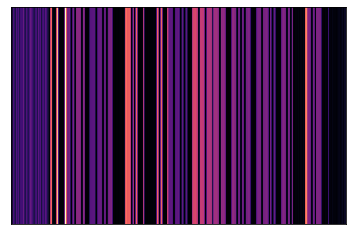

[['8', 'E', 'C', 'Q', 'D', 'E', 'I', 'Z', '0', 'X', 'Z', 'D', 'K', ' ']]
0.08585453033447266


In [26]:
import time

path = '/home/user/Downloads/websdr_recording_start_2019-11-19T19_11_02Z_7036.2kHz.wav'

sr = 8000
wave, sr = librosa.core.load(path, sr=sr)

wave = wave[16000:-8000]

#mel = dg.get_wave_mel_features(wave, sr, 1)
s = time.time()
wave = librosa.util.normalize(wave)
mel = librosa.feature.melspectrogram(wave, sr=sr, n_fft=500, n_mels=1, hop_length=200, power=2)
mel = mel.T
mel = mel / np.max(mel)
print(mel.shape)

librosa.display.specshow(mel.T)
plt.show()
#for i in range(1000):
    
to_pred = np.zeros([1,  mel.shape[0], mel_count])
to_pred[0,:,:] = mel

dec = decode_batch(get_all_layer_outputs, to_pred)

print(dec)

print((time.time() - s))